## EM Algorithm

- **Observables**: $x, y, \hat z$
- **Latent**: $z$
- **Model**:
    - $p(z)$: prior over latent $z$
    - $p(\hat z | z)$: observation model for $\hat z$
    - $p(y|z,x,\theta)$: likelihood model for $y$ parameterized by $\theta$ and conditioned on $z$ and $x$

The marginal likelihood is
\begin{align}
p(y|x,\hat z,\theta) &= \int p(y,z|x,\hat z,\theta) dz\\
&= \frac{\int p(y|z,x,\theta)p(\hat z|z)p(z)dz}{\int p(\hat z|z)p(z)dz}
\end{align}

- **E-step**: Infer latent variable $z$ based on current guess of parameters:
$$q(z) \leftarrow p(z|x,y,\hat z,\theta) \propto p(z)p(y,\hat z|z,\theta,x) = p(y|z,x,\theta)p(\hat z|z)p(z)$$
<!-- - **M-step**: $\theta = \text{argmax}_\theta\mathbb{E}_{q(z)}[p(y|z,x,\theta)p(\hat z|z)]$ -->
- **M-step**: Update parameters $\theta$ to maximize the expected log-likelihood of the observed data under that inferred $q(z)$:
$$\theta = \text{argmax}_\theta\mathbb{E}_{q(z)}[\log p(y|z,x,\theta)]$$

In [1]:
# Given:
# function model_lkhd(x, y, z, theta) = p(y|z,x,theta)
# grid size = [H, W]

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import MultivariateNormal
import matplotlib.pyplot as plt

# Set MPS fallback to enable operations not supported natively on Apple Silicon
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

import bopt
import h5py as h5
import utils

In [3]:
sample_rate = 50
device = bopt.cuda_init()  # Using specific GPU
# device='cuda:7'
samplerate = 50
num_before = 25
num_after = 5
seed = 2222
torch.random.manual_seed(seed)

--- device:0 has 1
--- device:1 has 1
--- device:2 has 3
--- device:3 has 1
--- device:4 has 1
--- device:5 has 1
--- device:6 has 0
--- device:7 has 0
Selected device: cuda:6


In [4]:
# Let's first load the h5 and see what's inside
h5_filepath = '/home/sunnyliu1220/git/latent-gaze/data/charm_50_rec_reduced.h5'
# charmander_clusters= [ 4, 15, 41, 42, 43, 50, 62, 107, 121, 168, 225, 226, 245, 251, 259, 261,
#     263, 271, 282, 294, 302, 327, 334, 340, 342, 347, 363, 364, 367, 375, 400,
#     555
# ]
charmander_clusters= [ 107, 124, 145, 154, 168, 225, 226, 247, 251, 261, 263, 271, 302, 309, 327, 334, 340, 342, 345, 363, 364, 375, 380, 555
] # From Zaki's leghorn charmander_shifted_neuralcollapse



In [5]:
# Let's verify the contents of our newly created H5 file
with h5.File(h5_filepath, 'r') as f:
    # Print the high-level structure
    print("Keys in the reduced h5 file:", list(f.keys()))
    
    # Check data structure
    print("\nData structure:")
    for series_key in f['data'].keys():
        print(f"  Series: {series_key}")
        for epoch_key in f['data'][series_key].keys():
            print(f"    Epoch: {epoch_key}")
            for group_key in f['data'][series_key][epoch_key].keys():
                print(f"      Group: {group_key}")
    
    # Check metadata
    print("\nMetadata structure:")
    for meta_key in f['meta'].keys():
        print(f"  {meta_key}")
    
    # Check file size
    import os
    print(f"\nFile size: {os.path.getsize(h5_filepath) / (1024*1024):.2f} MB")

Keys in the reduced h5 file: ['data', 'meta']

Data structure:
  Series: series_008
    Epoch: epoch_001
      Group: firing_rates
      Group: signals
      Group: stimulus
  Series: series_009
    Epoch: epoch_001
      Group: firing_rates
      Group: signals
      Group: stimulus

Metadata structure:
  cluster_ids
  reconstruction

File size: 636.14 MB


In [6]:
direction='shifted'
# test_series = ['series_008/epoch_001', 'series_009/epoch_001']
test_series = ['series_008/epoch_001']
test_idxs = [-samplerate * 10, -1]
test_all = [0, -1]

test_dataset_shifted = bopt.CorticalDataset(h5_filepath,
                                    test_series,
                                    num_before=num_before,
                                    num_after=num_after,
                                    start_idx=test_all[0],
                                    end_idx=test_all[1],
                                    stimulus_key='shifted',
                                    grayscale=True,
                                    normalize_signals=False,
                                    signals=['locomotion', 'azimuth'],
                                    which_clusters=charmander_clusters,
                                    zero_blinks=True)

test_loader_shifted = torch.utils.data.DataLoader(test_dataset_shifted,
                                          batch_size=256,
                                          shuffle=False)


Zeroing out blinks in stimulus (at init).


In [7]:
model_path = '/home/sunnyliu1220/git/latent-gaze/models/final_model.pt'
# Load the model
model = torch.load(model_path, map_location=device)
model.to(device)  # Explicitly move model to the device
model.eval()

/tmp/ipykernel_1031157/78538957.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=device)


CNNComponent(
  (layers): ModuleDict(
    (conv0): Conv2d(30, 24, kernel_size=(7, 7), stride=(1, 1), padding=valid)
    (layernorm0): LayerNorm((24, 62, 96), eps=1e-05, elementwise_affine=False)
    (dropout0): Dropout(p=0.1, inplace=False)
    (nl0): Softplus(beta=1.0, threshold=20.0)
    (conv1): Conv2d(24, 24, kernel_size=(7, 7), stride=(1, 1), padding=valid)
    (layernorm1): LayerNorm((24, 56, 90), eps=1e-05, elementwise_affine=False)
    (dropout1): Dropout(p=0.1, inplace=False)
    (nl1): Softplus(beta=1.0, threshold=20.0)
    (conv2): Conv2d(24, 24, kernel_size=(7, 7), stride=(1, 1), padding=valid)
    (layernorm2): LayerNorm((24, 50, 84), eps=1e-05, elementwise_affine=False)
    (dropout2): Dropout(p=0.1, inplace=False)
    (nl2): Softplus(beta=1.0, threshold=20.0)
    (conv3): Conv2d(24, 24, kernel_size=(7, 7), stride=(1, 1), padding=valid)
    (layernorm3): LayerNorm((24, 44, 78), eps=1e-05, elementwise_affine=False)
    (dropout3): Dropout(p=0.1, inplace=False)
    (nl3): S

In [8]:
# Let's define our sample
stim = test_dataset_shifted[0][0]
print("Stimulus shape:", stim.shape)
H = stim.shape[1]
W = stim.shape[2]
response = test_dataset_shifted[0][1]
print("Response shape:", response.shape)

Stimulus shape: torch.Size([30, 68, 102])
Response shape: torch.Size([24])


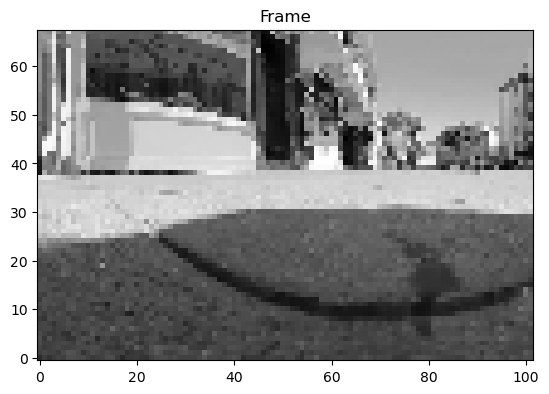

In [9]:
utils.plot_frame(stim[0], flip_y=True, title="Frame")

In [22]:
print("Stimulus shape:", stim[0].unsqueeze(0).shape)

Stimulus shape: torch.Size([1, 68, 102])


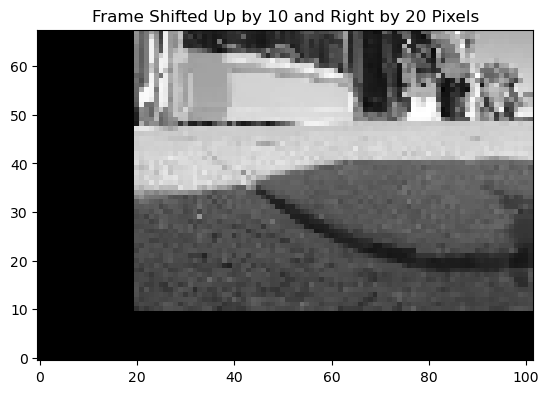

In [27]:
# Shift this frame up by 10 pixels and right by 20 pixels and plot
utils.plot_frame(utils.shift_stimulus(stim[0].unsqueeze(0), torch.tensor([10]), torch.tensor([20])).squeeze(), flip_y=True, title="Frame Shifted Up by 10 and Right by 20 Pixels")

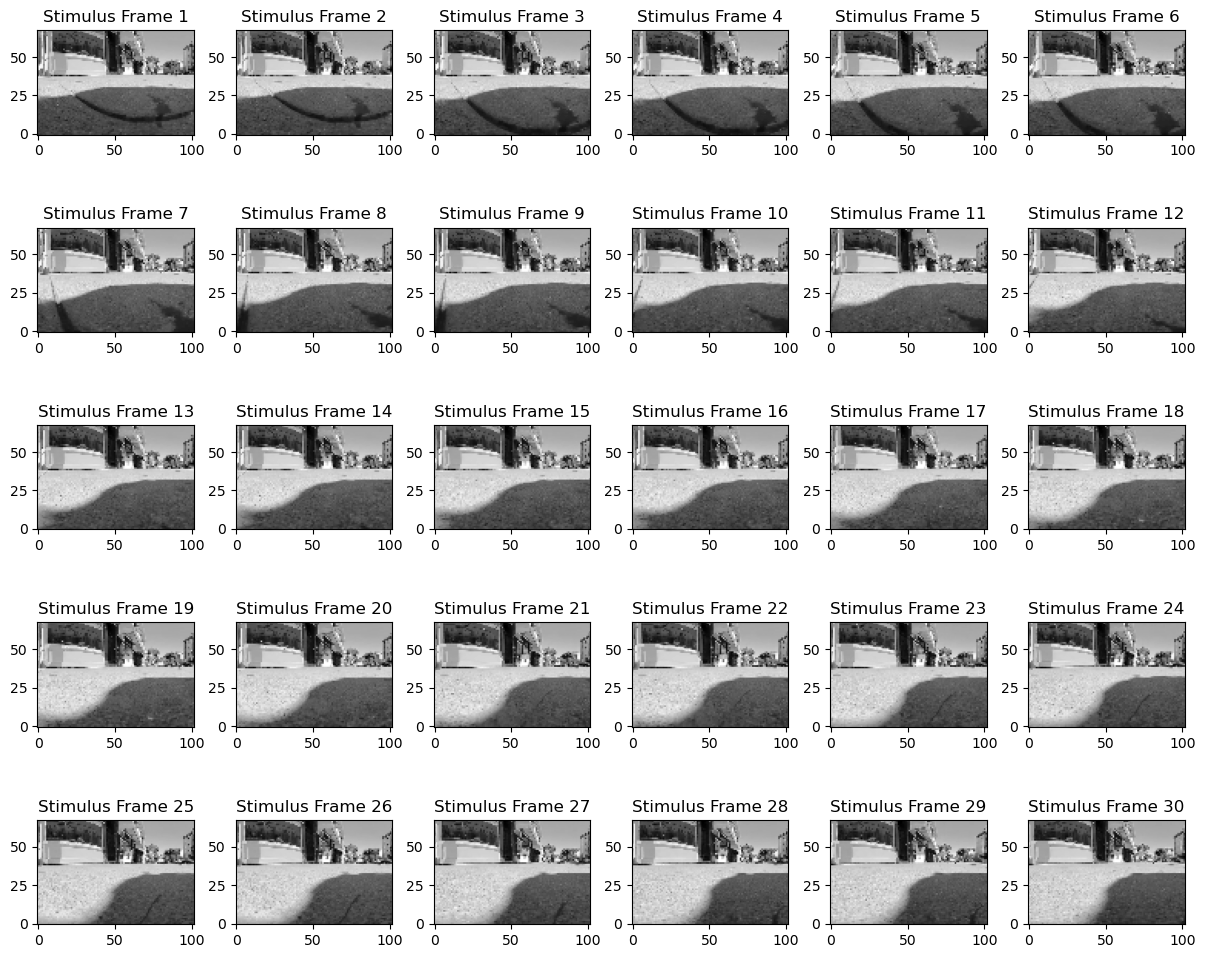

In [10]:
utils.plot_stimulus(stim, flip_y=True, title="Stimulus")

In [11]:
# Display the stimulus as an interactive movie viewer
print(f"Stimulus has {stim.shape[0]} frames")
print("Showing interactive stimulus viewer...")
utils.show_stimulus_movie(stim, flip_y=True, title="Stimulus Movie")

Stimulus has 30 frames
Showing interactive stimulus viewer...
Interactive slider for 30 frames (use slider below to navigate)


interactive(children=(IntSlider(value=0, description='Frame:', max=29), Output()), _dom_classes=('widget-inter…

In [12]:
# Let's estimate the variance of each neuron's response
all_responses = []
for i in range(len(test_dataset_shifted)):
    response = test_dataset_shifted[i][1]
    all_responses.append(response)
all_responses = torch.stack(all_responses, dim=0)
print("All responses shape:", all_responses.shape)

# Calculate the variance for each neuron across all samples
neuron_variances = torch.var(all_responses, dim=0)
print("Neuron variances shape:", neuron_variances.shape)
print ("Neuron variances:", neuron_variances)
var_mean = torch.mean(neuron_variances, dim=0)
print("All mean:", var_mean)

All responses shape: torch.Size([966, 24])
Neuron variances shape: torch.Size([24])
Neuron variances: tensor([0.0000e+00, 3.5875e+00, 5.6214e+01, 1.2472e+01, 1.0044e+02, 4.3521e+01,
        1.1881e+02, 1.0439e+02, 8.2785e+00, 2.7290e+02, 7.1644e+01, 1.2826e+02,
        2.1721e+02, 1.0541e+01, 4.2568e+02, 2.5419e+01, 1.3517e+02, 9.3341e+02,
        3.5047e+01, 7.2821e-01, 1.7322e+01, 5.6755e+00, 7.7601e+00, 4.2297e+02],
       dtype=torch.float64)
All mean: tensor(131.5602, dtype=torch.float64)


In [13]:
# Let's run a full EM algorithm.
q_z_prior = torch.ones((H, W), device=device) / (H * W)  # Uniform prior over pixels
z_hat = torch.tensor([H/2-0.5, W/2-0.5], device=device)  # Put z_hat on the correct device

In [14]:
# Run the complete EM algorithm
print("Running complete EM algorithm...")
print(f"Initial data shapes - Stimulus: {stim.shape}, Response: {response.shape}")
print(f"Grid size: {H}x{W}")
print(f"z_hat (eye position estimate): {z_hat}")

# Set up parameters for EM
EM_steps = 3  # Number of EM iterations
train_steps = 5  # Number of training steps per M-step
initial_lr = 1e-3  # Initial learning rate
sigma = 2.0  # Standard deviation for Gaussian likelihood p(z_hat | z)

# Run the EM algorithm
posteriors, log_lkhds, log_p_z_hat_given_z_list, updated_model, all_elbos = utils.run_EM(
    x=stim,
    y=response, 
    z_hat=z_hat,
    model=model,
    q_z_prior=q_z_prior,
    sigma=sigma,
    y_var=var_mean.item(),  # Use the computed variance
    batch_size=256,
    EM_steps=EM_steps,
    train_steps=train_steps,
    lr=initial_lr,
    device=device
)

print(f"\nEM algorithm completed!")
print(f"Number of posterior distributions stored: {len(posteriors)}")
print(f"Number of log likelihood arrays stored: {len(log_lkhds)}")
print(f"Number of log p(z_hat | z) arrays stored: {len(log_p_z_hat_given_z_list)}")
print(f"Total ELBO values collected: {len(all_elbos)}")

Running complete EM algorithm...
Initial data shapes - Stimulus: torch.Size([30, 68, 102]), Response: torch.Size([24])
Grid size: 68x102
z_hat (eye position estimate): tensor([33.5000, 50.5000], device='cuda:6')

EM Step 1/3
z_hat (eye position estimate): tensor([33.5000, 50.5000], device='cuda:6')

EM Step 1/3
Step 1/5, Loss: 12.5651
Step 1/5, Loss: 12.5651
Step 2/5, Loss: 1.9717
Step 2/5, Loss: 1.9717
Step 3/5, Loss: 0.4388
Step 3/5, Loss: 0.4388
Step 4/5, Loss: 0.2359
Step 4/5, Loss: 0.2359
Step 5/5, Loss: 0.3195
Updated learning rate: 0.001000

EM Step 2/3
Step 5/5, Loss: 0.3195
Updated learning rate: 0.001000

EM Step 2/3
Step 1/5, Loss: 0.2545
Step 1/5, Loss: 0.2545
Step 2/5, Loss: 19.9239
Step 2/5, Loss: 19.9239
Step 3/5, Loss: 1.4717
Step 3/5, Loss: 1.4717
Step 4/5, Loss: 0.3491
Step 4/5, Loss: 0.3491
Step 5/5, Loss: 0.0305
Updated learning rate: 0.000200

EM Step 3/3
Step 5/5, Loss: 0.0305
Updated learning rate: 0.000200

EM Step 3/3
Step 1/5, Loss: 0.2345
Step 1/5, Loss: 0.23

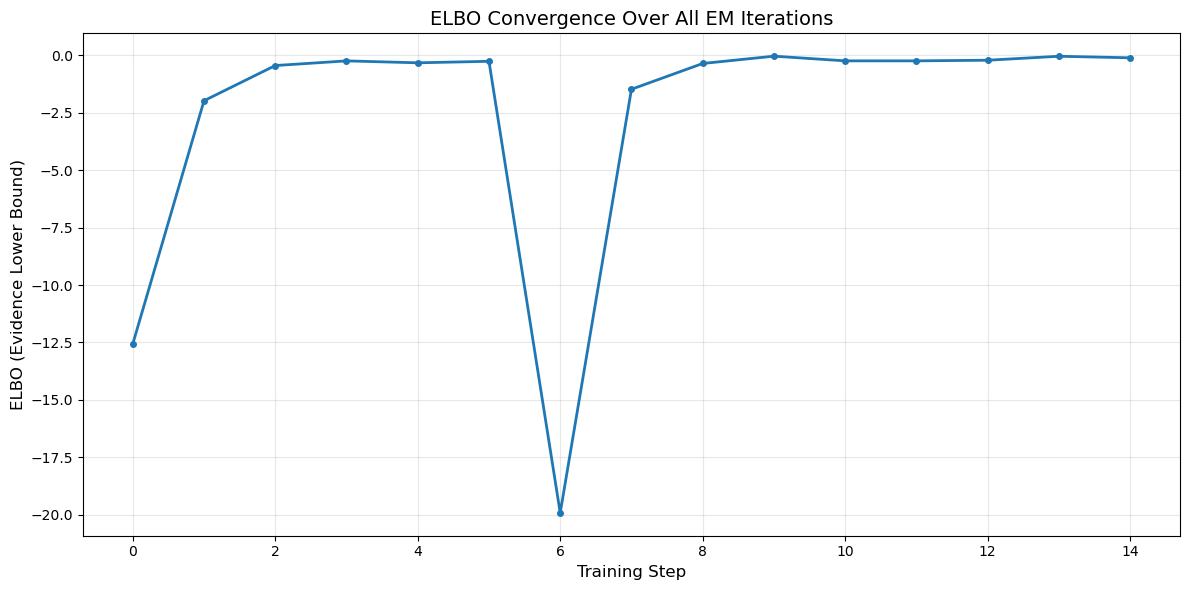

Initial ELBO: -12.5651
Final ELBO: -0.1013
Total improvement: 12.4638


In [15]:
# Plot ELBO convergence over all EM iterations
plt.figure(figsize=(12, 6))
plt.plot(all_elbos, marker='o', linewidth=2, markersize=4)
plt.title('ELBO Convergence Over All EM Iterations', fontsize=14)
plt.xlabel('Training Step', fontsize=12)
plt.ylabel('ELBO (Evidence Lower Bound)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Initial ELBO: {all_elbos[0]:.4f}")
print(f"Final ELBO: {all_elbos[-1]:.4f}")
print(f"Total improvement: {all_elbos[-1] - all_elbos[0]:.4f}")

E-step 1: sum=1.000000, max=0.090233
E-step 2: sum=1.000000, max=0.094149
E-step 3: sum=1.000000, max=0.255677
E-step 4: sum=1.000000, max=0.321538


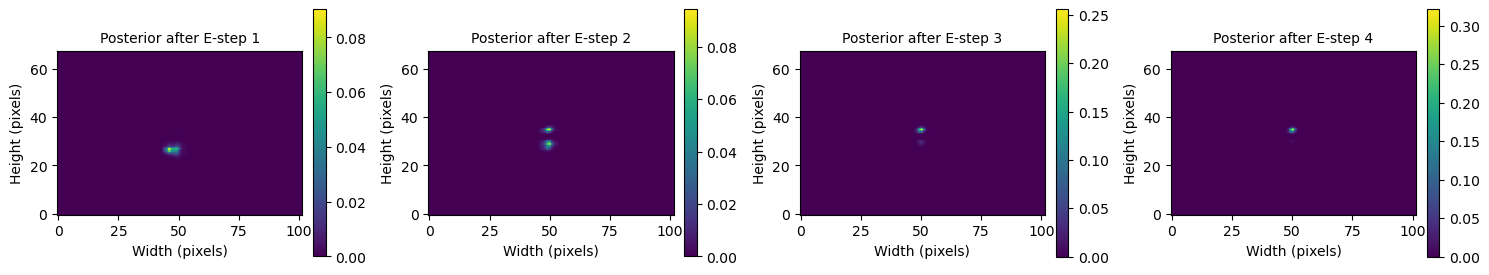

In [16]:
# Visualize the evolution of posterior distributions
fig, axes = plt.subplots(1, len(posteriors), figsize=(15, 4))
if len(posteriors) == 1:
    axes = [axes]  # Ensure axes is always a list

for i, posterior in enumerate(posteriors):
    if i < len(axes):
        im = axes[i].imshow(posterior.cpu().numpy(), cmap='viridis')
        axes[i].set_title(f'Posterior after E-step {i+1}', fontsize=10)
        axes[i].invert_yaxis()  # Flip y-axis to match previous plots
        axes[i].set_xlabel('Width (pixels)')
        axes[i].set_ylabel('Height (pixels)')
        plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
        
        # Print statistics for each posterior
        print(f"E-step {i+1}: sum={posterior.sum().item():.6f}, max={posterior.max().item():.6f}")

# Hide unused subplots
for i in range(len(posteriors), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

E-step 1: max_log_lkhd=-2.10, mean_log_lkhd=-13.30
E-step 2: max_log_lkhd=-0.26, mean_log_lkhd=-0.27
E-step 3: max_log_lkhd=-0.26, mean_log_lkhd=-0.26
E-step 4: max_log_lkhd=-0.15, mean_log_lkhd=-0.15


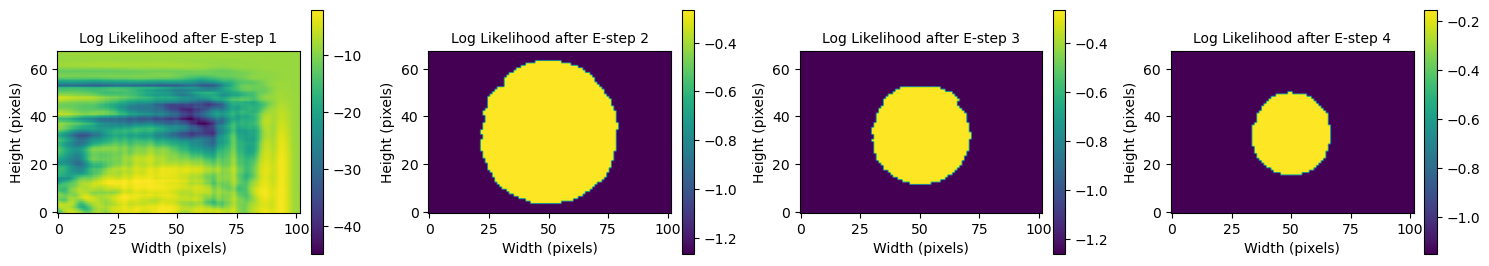


Log Likelihood Evolution Summary:
E-step 1: Max=-2.10, Mean=-13.30, Std=8.20
E-step 2: Max=-0.26, Mean=-0.27, Std=0.00
E-step 3: Max=-0.26, Mean=-0.26, Std=0.00
E-step 4: Max=-0.15, Mean=-0.15, Std=0.00


In [17]:
# Visualize the evolution of log likelihoods over EM steps
fig, axes = plt.subplots(1, len(log_lkhds), figsize=(15, 4))
if len(log_lkhds) == 1:
    axes = [axes]  # Ensure axes is always a list

for i, log_lkhd in enumerate(log_lkhds):
    if i < len(axes):
        # Reshape log likelihood to 2D grid
        log_lkhd_2d = log_lkhd.reshape(H, W).cpu().numpy()
        
        # Handle -inf values for better visualization
        log_lkhd_display = log_lkhd_2d.copy()
        finite_mask = np.isfinite(log_lkhd_display)
        if finite_mask.any():
            min_finite = log_lkhd_display[finite_mask].min()
            log_lkhd_display[~finite_mask] = min_finite - 1
        
        im = axes[i].imshow(log_lkhd_display, cmap='viridis')
        axes[i].set_title(f'Log Likelihood after E-step {i+1}', fontsize=10)
        axes[i].invert_yaxis()  # Flip y-axis to match previous plots
        axes[i].set_xlabel('Width (pixels)')
        axes[i].set_ylabel('Height (pixels)')
        plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
        
        # Print statistics for each log likelihood
        finite_values = log_lkhd[torch.isfinite(log_lkhd)]
        if len(finite_values) > 0:
            print(f"E-step {i+1}: max_log_lkhd={finite_values.max().item():.2f}, mean_log_lkhd={finite_values.mean().item():.2f}")
        else:
            print(f"E-step {i+1}: No finite log likelihood values")

# Hide unused subplots
for i in range(len(log_lkhds), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Show improvement in log likelihood concentration
print("\nLog Likelihood Evolution Summary:")
for i, log_lkhd in enumerate(log_lkhds):
    finite_values = log_lkhd[torch.isfinite(log_lkhd)]
    if len(finite_values) > 0:
        max_val = finite_values.max().item()
        mean_val = finite_values.mean().item()
        std_val = finite_values.std().item()
        print(f"E-step {i+1}: Max={max_val:.2f}, Mean={mean_val:.2f}, Std={std_val:.2f}")
    else:
        print(f"E-step {i+1}: No finite values")

E-step 1: max_log_p=-3.29, mean_log_p=-159.74
E-step 2: max_log_p=-3.29, mean_log_p=-57.76
E-step 3: max_log_p=-3.29, mean_log_p=-30.55
E-step 4: max_log_p=-3.29, mean_log_p=-21.46
E-step 4: max_log_p=-3.29, mean_log_p=-21.46


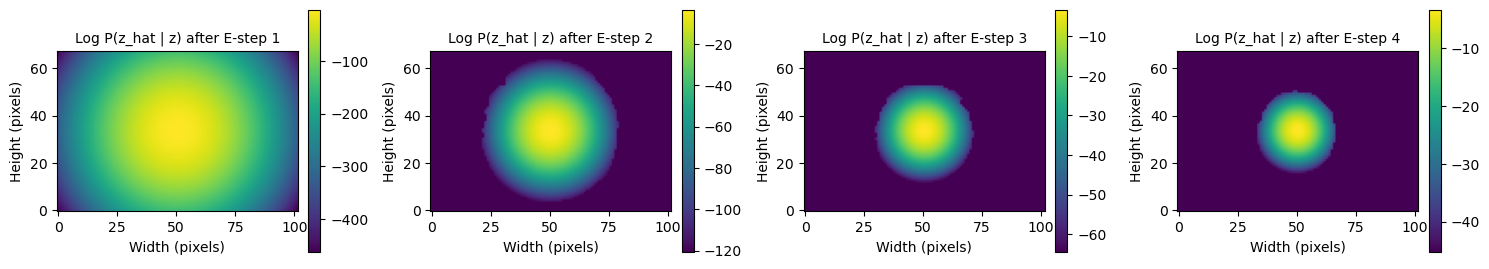


Log P(z_hat | z) Evolution Summary:
E-step 1: Max=-3.29, Mean=-159.74, Std=106.05
E-step 2: Max=-3.29, Mean=-57.76, Std=31.65
E-step 3: Max=-3.29, Mean=-30.55, Std=16.01
E-step 4: Max=-3.29, Mean=-21.46, Std=10.71


In [18]:
# Visualize the evolution of log p(z_hat | z) over EM steps
fig, axes = plt.subplots(1, len(log_p_z_hat_given_z_list), figsize=(15, 4))
if len(log_p_z_hat_given_z_list) == 1:
    axes = [axes]  # Ensure axes is always a list

for i, log_p_z_hat_given_z in enumerate(log_p_z_hat_given_z_list):
    if i < len(axes):
        # Reshape log p(z_hat | z) to 2D grid
        log_p_z_hat_given_z_2d = log_p_z_hat_given_z.reshape(H, W).cpu().numpy()
        
        # Handle -inf values for better visualization
        log_p_display = log_p_z_hat_given_z_2d.copy()
        finite_mask = np.isfinite(log_p_display)
        if finite_mask.any():
            min_finite = log_p_display[finite_mask].min()
            log_p_display[~finite_mask] = min_finite - 1
        
        im = axes[i].imshow(log_p_display, cmap='viridis')
        axes[i].set_title(f'Log P(z_hat | z) after E-step {i+1}', fontsize=10)
        axes[i].invert_yaxis()  # Flip y-axis to match previous plots
        axes[i].set_xlabel('Width (pixels)')
        axes[i].set_ylabel('Height (pixels)')
        plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
        
        # Print statistics for each log p(z_hat | z)
        finite_values = log_p_z_hat_given_z[torch.isfinite(log_p_z_hat_given_z)]
        if len(finite_values) > 0:
            print(f"E-step {i+1}: max_log_p={finite_values.max().item():.2f}, mean_log_p={finite_values.mean().item():.2f}")
        else:
            print(f"E-step {i+1}: No finite log p(z_hat | z) values")

# Hide unused subplots
for i in range(len(log_p_z_hat_given_z_list), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Show summary of log p(z_hat | z) evolution
print("\nLog P(z_hat | z) Evolution Summary:")
for i, log_p_z_hat_given_z in enumerate(log_p_z_hat_given_z_list):
    finite_values = log_p_z_hat_given_z[torch.isfinite(log_p_z_hat_given_z)]
    if len(finite_values) > 0:
        max_val = finite_values.max().item()
        mean_val = finite_values.mean().item()
        std_val = finite_values.std().item()
        print(f"E-step {i+1}: Max={max_val:.2f}, Mean={mean_val:.2f}, Std={std_val:.2f}")
    else:
        print(f"E-step {i+1}: No finite values")

## Scratch below this

In [13]:
# Check data types before E_step
print(f"stim dtype: {stim.dtype}")
print(f"response dtype: {response.dtype}")

# Convert to float32 to match model weights
stim = stim.float()
response = response.float()

q_z_prior = torch.ones((H, W), device=device) / (H * W)  # Uniform prior over pixels
z_hat = torch.tensor([H/2-0.5, W/2-0.5], device=device)  # Put z_hat on the correct device
q_z, log_lkhd, log_p_z_hat_given_z = utils.E_step(stim, response, z_hat, model, q_z_prior, sigma=2.0, device=device)

stim dtype: torch.float64
response dtype: torch.float64


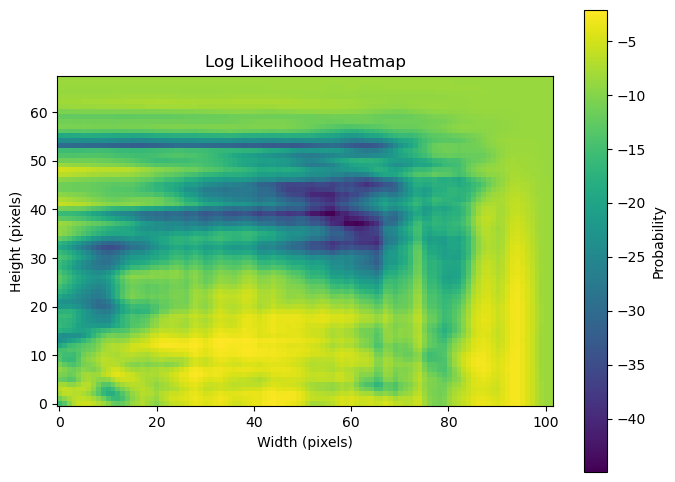

In [14]:
log_lkhd = log_lkhd.reshape(H, W)
# Plot log_lkhd as a 2D heatmap
utils.plot_distribution(log_lkhd, title="Log Likelihood Heatmap", flip_y=True, cmap='viridis')

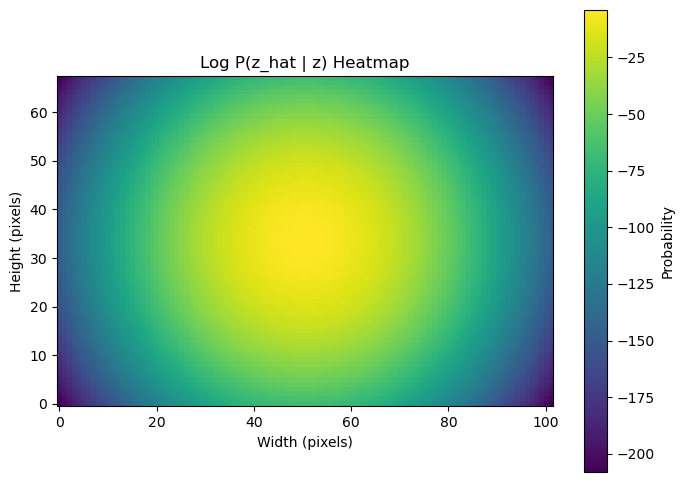

In [15]:
log_p_z_hat_given_z = log_p_z_hat_given_z.reshape(H, W)
# Plot log_p_z_hat_given_z as a 2D heatmap
utils.plot_distribution(log_p_z_hat_given_z, title="Log P(z_hat | z) Heatmap", flip_y=True, cmap='viridis')

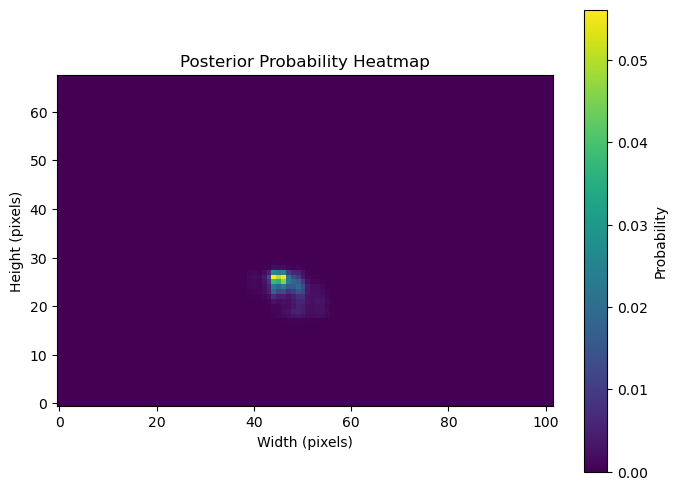

q_z shape: torch.Size([68, 102])
q_z sum: 1.000000
q_z max: 0.056157
q_z min: 0.000000


In [16]:
# Plot q_z as a 2D heatmap
utils.plot_distribution(q_z, title="Posterior Probability Heatmap", flip_y=True, cmap='viridis')

# Print some statistics
print(f"q_z shape: {q_z.shape}")
print(f"q_z sum: {q_z.sum().item():.6f}")
print(f"q_z max: {q_z.max().item():.6f}")
print(f"q_z min: {q_z.min().item():.6f}")

Step 1/10, Loss: 9.1398
Step 2/10, Loss: 2.0744
Step 3/10, Loss: 1.3350
Step 4/10, Loss: 1.0659
Step 5/10, Loss: 0.2231
Step 6/10, Loss: 0.4438
Step 7/10, Loss: 0.5506
Step 8/10, Loss: 0.3933
Step 9/10, Loss: 0.1920
Step 10/10, Loss: 0.0546


Text(0, 0.5, 'ELBO')

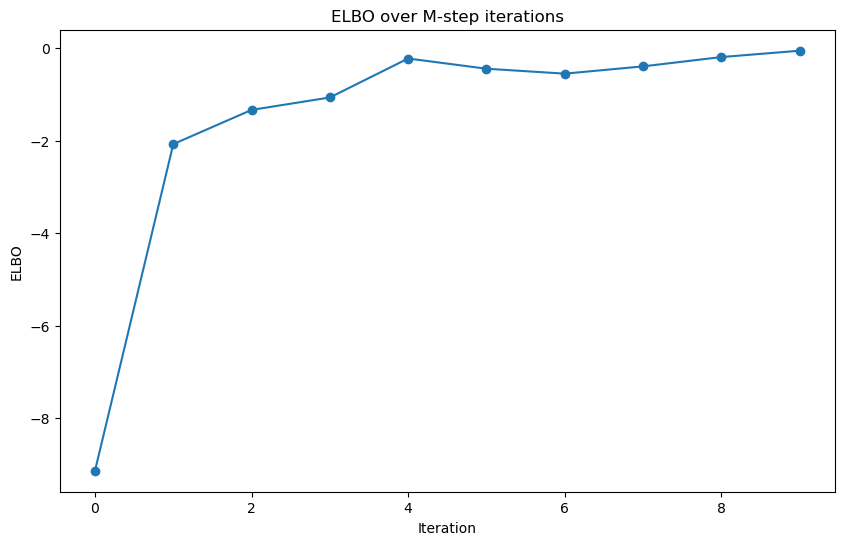

In [17]:
# Run the M step
model, elbos, lr = utils.M_step(stim, response, q_z, model, lr=1e-3, steps=10, device=device)
# Plot the ELBO over steps
plt.figure(figsize=(10, 6))
plt.plot(elbos, marker='o')
plt.title('ELBO over M-step iterations')
plt.xlabel('Iteration')
plt.ylabel('ELBO')

In [18]:
# Run E step again after M step
q_z, log_lkhd, log_p_z_hat_given_z = utils.E_step(stim, response, z_hat, model, q_z, sigma=2.0, device=device)

In [19]:
# Print the shapes
print(f"q_z shape after M step: {q_z.shape}")
print(f"log_lkhd shape after M step: {log_lkhd.shape}")
print(f"log_p_z_hat_given_z shape after M step: {log_p_z_hat_given_z.shape}")

q_z shape after M step: torch.Size([68, 102])
log_lkhd shape after M step: torch.Size([6936])
log_p_z_hat_given_z shape after M step: torch.Size([6936])


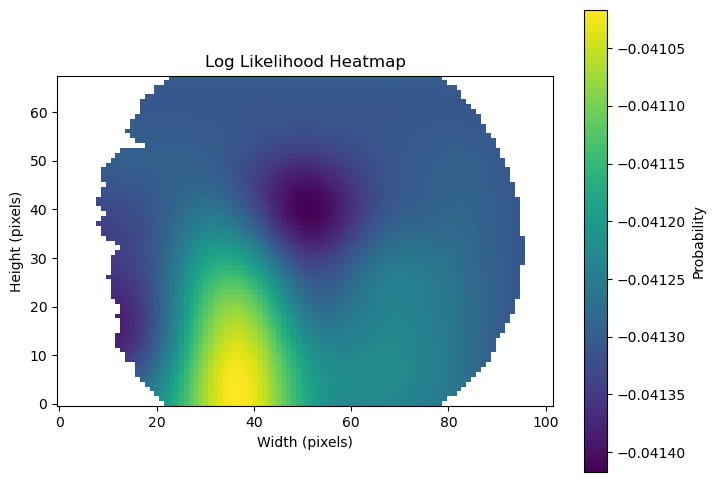

In [20]:
log_lkhd = log_lkhd.reshape(H, W)
# Plot log_lkhd as a 2D heatmap
utils.plot_distribution(log_lkhd, title="Log Likelihood Heatmap", flip_y=True, cmap='viridis')

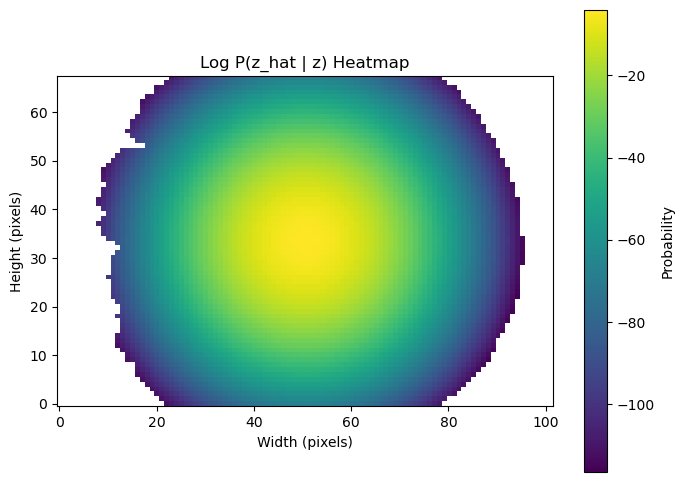

In [21]:
log_p_z_hat_given_z = log_p_z_hat_given_z.reshape(H, W)
# Plot log_p_z_hat_given_z as a 2D heatmap
utils.plot_distribution(log_p_z_hat_given_z, title="Log P(z_hat | z) Heatmap", flip_y=True, cmap='viridis')

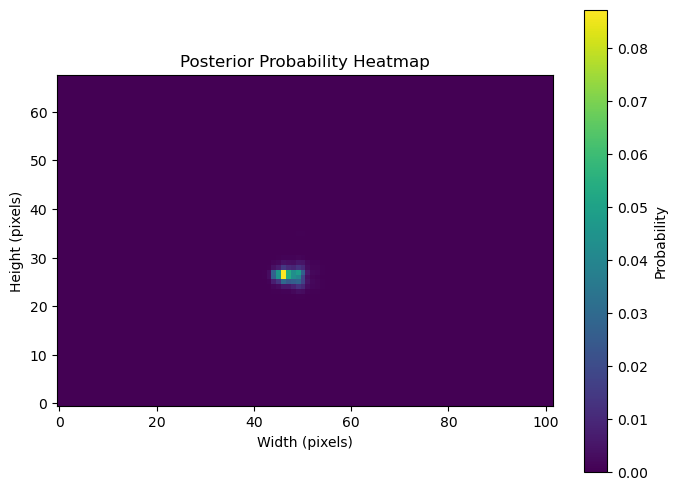

q_z shape: torch.Size([68, 102])
q_z sum: 1.000000
q_z max: 0.087209
q_z min: 0.000000


In [22]:
# Plot q_z as a 2D heatmap
utils.plot_distribution(q_z, title="Posterior Probability Heatmap", flip_y=True, cmap='viridis')

# Print some statistics
print(f"q_z shape: {q_z.shape}")
print(f"q_z sum: {q_z.sum().item():.6f}")
print(f"q_z max: {q_z.max().item():.6f}")
print(f"q_z min: {q_z.min().item():.6f}")

Step 1/10, Loss: 0.0430
Step 2/10, Loss: 76.8573
Step 3/10, Loss: 4.0931
Step 4/10, Loss: 2.9352
Step 5/10, Loss: 2.3070
Step 6/10, Loss: 2.2369
Step 7/10, Loss: 2.1875
Step 8/10, Loss: 2.1782
Step 9/10, Loss: 2.1733
Step 10/10, Loss: 2.1738


Text(0, 0.5, 'ELBO')

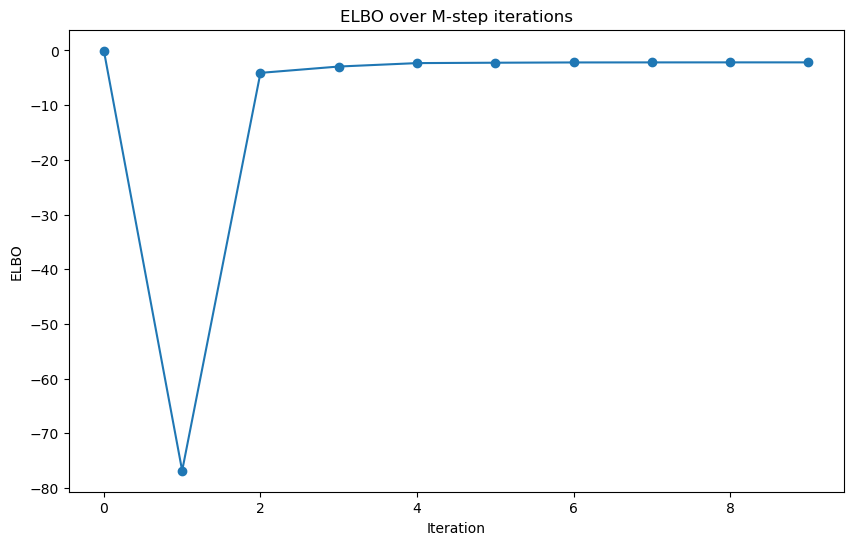

In [23]:
# Do it again
# Run the M step
model, elbos, lr = utils.M_step(stim, response, q_z, model, lr=1e-3, steps=10, device=device)
# Plot the ELBO over steps
plt.figure(figsize=(10, 6))
plt.plot(elbos, marker='o')
plt.title('ELBO over M-step iterations')
plt.xlabel('Iteration')
plt.ylabel('ELBO')

In [24]:
# Run E step again after M step
q_z, log_lkhd, log_p_z_hat_given_z = utils.E_step(stim, response, z_hat, model, q_z, sigma=2.0, device=device)

In [25]:
# Print the shapes
print(f"q_z shape after M step: {q_z.shape}")
print(f"log_lkhd shape after M step: {log_lkhd.shape}")
print(f"log_p_z_hat_given_z shape after M step: {log_p_z_hat_given_z.shape}")

q_z shape after M step: torch.Size([68, 102])
log_lkhd shape after M step: torch.Size([6936])
log_p_z_hat_given_z shape after M step: torch.Size([6936])


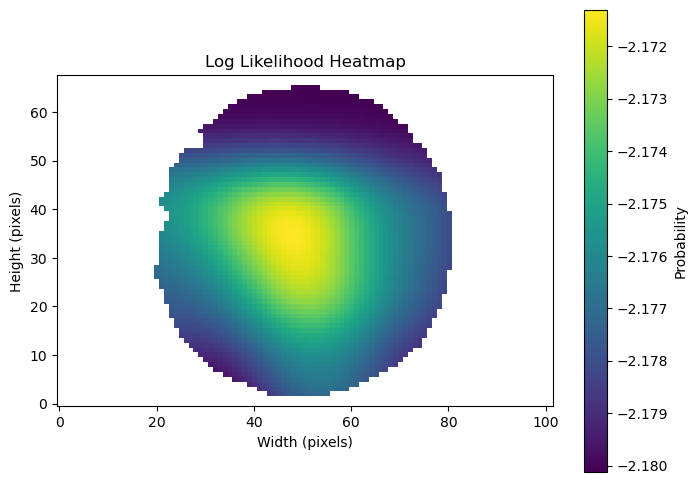

In [26]:
log_lkhd = log_lkhd.reshape(H, W)
# Plot log_lkhd as a 2D heatmap
utils.plot_distribution(log_lkhd, title="Log Likelihood Heatmap", flip_y=True, cmap='viridis')

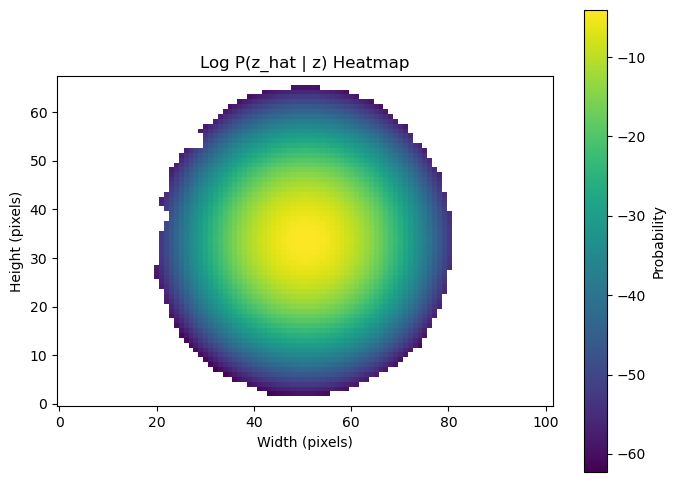

In [27]:
log_p_z_hat_given_z = log_p_z_hat_given_z.reshape(H, W)
# Plot log_p_z_hat_given_z as a 2D heatmap
utils.plot_distribution(log_p_z_hat_given_z, title="Log P(z_hat | z) Heatmap", flip_y=True, cmap='viridis')

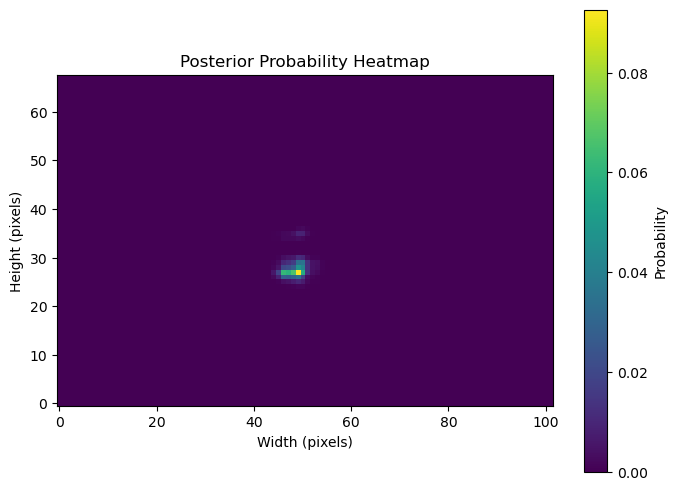

q_z shape: torch.Size([68, 102])
q_z sum: 1.000000
q_z max: 0.092703
q_z min: 0.000000


In [28]:
# Plot q_z as a 2D heatmap
utils.plot_distribution(q_z, title="Posterior Probability Heatmap", flip_y=True, cmap='viridis')

# Print some statistics
print(f"q_z shape: {q_z.shape}")
print(f"q_z sum: {q_z.sum().item():.6f}")
print(f"q_z max: {q_z.max().item():.6f}")
print(f"q_z min: {q_z.min().item():.6f}")